# Montana Board of Oil and Gas Conservation

The purpose of this notebook is to outline the process for collecting oil and gas data from the state of Montana, how to transform the data into something useful for analysis, and to perform some initial EDA

# Data Collection
Start by extracting the data from the following link

In [62]:
# importing libraries
import zipfile
from urllib.request import urlopen
import shutil
import os
import pandas as pd
import seaborn as sns

url = 'http://bogc.dnrc.mt.gov/production/historical.zip'
file_name = 'historical.zip'

# extracting zipfile from URL
with urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

    # extracting required file from zipfile
    with zipfile.ZipFile(file_name) as zf:
        zf.extract('histLeaseProd.tab')
        zf.extract('histprodwell.tab')
        zf.extract('histWellData.tab')

# deleting the zipfile from the directory
os.remove('historical.zip')

# loading data from the file
lease_prod_df = pd.read_csv('histLeaseProd.tab', sep='\t')
well_prod_df = pd.read_csv('histprodwell.tab', sep='\t')
well_data_df = pd.read_csv('histWellData.tab', sep='\t')

C:\Users\josep\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# View Data
Let's start by taking a look at these 3 files pulled from the .zip file. There are three flat files. `lease_prod_df` contains production reported on a lease basis, `well_prod_df` contains production on a per well monthly basis, and `well_data_df` contains the well information (Producting status, field, horizontal, vertical drill profile, etc.)

In [63]:
lease_prod_df.head()

,Lease_Unit,Rpt_Date,Dt_Receive,Del_Rpt,Amnd_Rpt,OpNo,CoName,StartIvn_OilCd,Oil_Prod,Gas_Prod,...,WtrInj,WtrTo_Pit,Other_Oil,Other_Gas,Other_Wtr,Dt_Amend,Lease_Update,No_ProdWells,No_SIWells,Dt_Mod
0,2,01/31/2001,03/15/2001,False,False,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,353.0,...,0.0,0.0,0.0,0.0,0.0,NaN,False,1.0,0.0,05/18/2001
1,3,01/31/2001,03/15/2001,False,False,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,69.0,...,0.0,0.0,0.0,0.0,0.0,NaN,False,1.0,0.0,05/18/2001
2,4,01/31/2001,03/05/2001,False,False,6681,Samedan Oil Corporation,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,False,0.0,1.0,03/06/2001
3,5,01/31/2001,03/05/2001,False,False,6681,Samedan Oil Corporation,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,False,0.0,1.0,03/06/2001
4,6,01/31/2001,03/05/2001,False,False,6681,Samedan Oil Corporation,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,False,0.0,1.0,03/06/2001


In [64]:
lease_prod_df.describe()

,Lease_Unit,OpNo,StartIvn_OilCd,Oil_Prod,Gas_Prod,Wtr_Prod,Oil_Sold,Gas_Sold,OilSpill,WtrSpill,...,UseGas,OilInj,GasInj,WtrInj,WtrTo_Pit,Other_Oil,Other_Gas,Other_Wtr,No_ProdWells,No_SIWells
count,1.298191e+06,1.298191e+06,1.283575e+06,1.298181e+06,1.297562e+06,1.297373e+06,1.297370e+06,1.298186e+06,1.297238e+06,78134.000000,...,1.298188e+06,1.297233e+06,1.298187e+06,1.279484e+06,1.279527e+06,1.286605e+06,1.298187e+06,1.279363e+06,1.298170e+06,1.288983e+06
mean,1.370504e+04,1.717545e+03,9.998504e+01,4.047499e+02,1.476859e+03,2.764494e+03,4.047213e+02,1.132646e+03,3.033368e-03,0.020900,...,4.778551e+01,3.475860e-03,2.352886e+02,1.616128e+03,3.201118e+02,1.094641e-01,3.267775e+00,2.214530e+02,1.815966e+00,7.251414e-01
std,3.718679e+04,2.344972e+03,2.078206e+02,3.377169e+03,3.272934e+04,3.604075e+04,3.378501e+03,9.589917e+03,6.614214e-01,5.485964,...,4.437782e+02,1.120417e+00,3.114522e+04,3.160498e+04,9.859811e+03,1.468871e+01,1.465689e+02,8.156987e+03,1.024098e+01,4.598063e+00
min,2.000000e+00,4.000000e+00,-8.150000e+02,-4.020000e+02,0.000000e+00,-5.150000e+02,-2.300000e+02,0.000000e+00,0.000000e+00,0.000000,...,-8.190000e+02,-4.800000e+01,0.000000e+00,-9.300000e+01,-5.000000e+01,-8.580000e+03,-5.540000e+02,-7.055000e+04,0.000000e+00,0.000000e+00
25%,2.666000e+03,3.210000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,5.251000e+03,5.360000e+02,0.000000e+00,0.000000e+00,1.380000e+02,0.000000e+00,0.000000e+00,6.900000e+01,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,7.387000e+03,1.720000e+03,1.460000e+02,1.170000e+02,7.100000e+02,1.250000e+02,1.220000e+02,5.980000e+02,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,9.900150e+05,1.230600e+04,8.493000e+03,2.318970e+05,5.934068e+06,6.684198e+06,2.319860e+05,6.788670e+05,2.480000e+02,1530.000000,...,7.351400e+04,9.890000e+02,5.934068e+06,2.096867e+06,6.684198e+06,3.000000e+03,2.473100e+04,8.252006e+06,1.154000e+03,1.200000e+03


In [65]:
well_prod_df.head()

,rpt_date,API_WELLNO,ST_FMTN_CD,Name_,Lease_Unit,OPNO,CoName,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,STATUS,dt_mod
0,12/30/1899,25035061990000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
1,12/30/1899,25035062030000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
2,12/30/1899,25035062220000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
3,12/30/1899,25035062380000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
4,12/30/1899,25035062860000,CB,Cut Bank,2203.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/10/2020


In [66]:
well_prod_df.describe()

,API_WELLNO,Lease_Unit,OPNO,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD
count,5.028322e+06,5.028292e+06,4.181218e+06,5.028320e+06,5.028321e+06,5.028322e+06,5.028249e+06
mean,2.506244e+13,8.618911e+03,1.789600e+03,1.612155e+02,5.443820e+02,1.058946e+03,1.940332e+01
std,3.397980e+10,3.509633e+04,2.436512e+03,6.258063e+02,2.798577e+03,6.467663e+03,1.495651e+01
min,2.500305e+13,-9.990000e+02,4.000000e+00,-4.020000e+02,-6.050000e+02,-4.120000e+03,-3.400000e+01
25%,2.503506e+13,1.583000e+03,3.210000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.507122e+13,2.785000e+03,5.310000e+02,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
75%,2.509960e+13,4.829000e+03,2.323000e+03,2.800000e+01,4.490000e+02,6.100000e+01,3.100000e+01
max,2.511192e+13,9.900150e+05,1.230600e+04,4.519700e+04,3.429430e+05,2.944924e+06,3.130000e+03


In [67]:
well_data_df.head()

,API_WellNo,OpNo,CoName,Well_Nm,Well_Typ,Type,Wl_Status,Status,Wh_Sec,Wh_Twpn,...,Wh_EW,Slant,Reg_Field_No,Reg_Field,Stat_Field_No,Stat_Field,Dt_APD,Dt_Cmp,Elev_KB,DTD
0,25101100140000,7120,"Somont Oil Company, Inc.",Remington-Warner 7,OIL,Oil,PR,Producing,32,35,...,W,V,4820,Kevin-Sunburst,4820,Kevin-Sunburst,NaN,1927-07-05 00:00:00,NaN,1500.0
1,25025225200000,664,"Denbury Onshore, LLC",Little Beaver East 23-22H,OIL,Oil,SI,Shut In,22,5,...,W,H,5420,"Little Beaver, East",5420,"Little Beaver, East",2005-04-12 00:00:00,2006-01-27 00:00:00,2989.0,11250.0
2,25073210450000,5130,Mont Mil Operating Company,TMCBSU 10-10,EOR,"Injection, EOR",AX,P&A - Approved,10,31,...,W,V,2400,Cut Bank,2400,Cut Bank,1968-11-25 00:00:00,1969-07-15 00:00:00,NaN,3422.0
3,25065055920000,645,Kelly Oil and Gas LLC,Smith M #3,OIL,Oil,SI,Shut In,12,10,...,E,V,4700,Keg Coulee,4700,Keg Coulee,1966-10-20 00:00:00,1966-12-17 00:00:00,NaN,4855.0
4,25101226430000,4070,Kipling Energy Incorporated,Allen 4,OIL,Oil,AX,P&A - Approved,11,34,...,E,V,4820,Kevin-Sunburst,4820,Kevin-Sunburst,1984-07-20 00:00:00,1984-08-16 00:00:00,NaN,1588.0


There are few columns that are interesting to investigate here. For example, how many OIl vs. EOR wells are there?

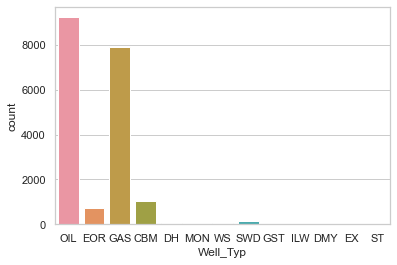

In [74]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Well_Typ", data=well_data_df)

In [68]:
well_data_df.describe()

,API_WellNo,OpNo,Wh_Sec,Wh_Twpn,Wh_RngN,Wh_FtNS,Wh_FtEW,Reg_Field_No,Stat_Field_No,Elev_KB,DTD
count,1.928100e+04,19281.000000,19281.000000,19281.000000,19281.000000,19257.000000,19257.000000,19281.000000,19281.000000,9045.000000,19229.000000
mean,2.505986e+13,1659.379648,18.664281,25.581920,27.848400,1290.213792,1334.870541,5244.297806,4405.151289,2996.814594,4281.091892
std,3.456461e+10,2364.241800,10.166079,11.176755,22.138558,711.827299,685.701671,3383.384804,2756.568076,635.346835,4731.850855
min,2.500305e+13,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,5.000000,1890.000000,89.000000
25%,2.502523e+13,369.000000,10.000000,13.000000,5.000000,660.000000,691.000000,2400.000000,2400.000000,2456.000000,1505.000000
50%,2.507122e+13,676.000000,19.000000,31.000000,29.000000,1229.000000,1315.000000,4820.000000,4120.000000,2963.000000,2000.000000
75%,2.509121e+13,891.000000,27.000000,35.000000,54.000000,1972.000000,1980.000000,8100.000000,6680.000000,3478.000000,4650.000000
max,2.511192e+13,12317.000000,36.000000,37.000000,62.000000,7090.000000,4937.000000,11111.000000,11111.000000,6252.000000,24821.000000


# Clean

Remove wells and leases that have no hydrocarbon production. This could be due to wells only producing water, or problems with reporting. 

In [69]:
well_prd_total = well_prod_df.groupby(['API_WELLNO']).sum() #sum the producing streams by api
well_prd_total['BOE'] = well_prd_total['BBLS_OIL_COND'] + well_prd_total['MCF_GAS']/5.8 #get total bbls of oil equivalent
well_prd_total = well_prd_total[well_prd_total['BOE']>0] #drop wells that didn't produce any oil and/or gas
api_list = list(well_prd_total.index) #get list of the api #'s that are associated with wells that had non-zero production
well_prod_df = well_prod_df[well_prod_df['API_WELLNO'].isin(api_list)]
well_prd_total.describe()


,Lease_Unit,OPNO,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,BOE
count,1.746500e+04,1.746500e+04,1.746500e+04,1.746500e+04,1.746500e+04,17465.000000,17465.000000,1.746500e+04
mean,2.142022e+06,3.965643e+05,4.641529e+04,1.567322e+05,2.988980e+05,5578.692585,17.529001,7.343808e+04
std,7.552864e+06,5.568571e+05,1.116399e+05,3.585895e+05,1.303211e+06,3900.633634,25.402970,1.346893e+05
min,-1.078920e+05,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00,0.000000,0.000000,1.724138e-01
25%,3.746040e+05,7.170500e+04,0.000000e+00,0.000000e+00,4.000000e+00,2332.000000,1.000000,5.520000e+03
50%,8.183000e+05,1.766620e+05,1.030000e+02,5.192100e+04,5.907000e+03,5112.000000,6.000000,2.395759e+04
75%,1.358656e+06,5.026800e+05,2.256300e+04,1.923530e+05,1.103170e+05,8634.000000,26.000000,6.951221e+04
max,9.782733e+07,8.569120e+06,1.321254e+06,7.463147e+06,4.249243e+07,21819.000000,266.000000,1.702024e+06


In [70]:
lease_prd_total = lease_prod_df.groupby(['Lease_Unit']).sum() #sum the producing streams by lease unit
lease_prd_total['BOE'] = lease_prd_total['Oil_Prod'] + lease_prd_total['Gas_Prod']/5.8 #get total bbls of oil equivalent
lease_prd_total = lease_prd_total[lease_prd_total['BOE']>0] #drop leases that didn't produce any oil and/or gas
lease_list = list(lease_prd_total.index) #get list of the lease unit #'s that are associated with leases that had non-zero production
lease_prod_df = lease_prod_df[lease_prod_df['Lease_Unit'].isin(lease_list)]
lease_prd_total.describe()

,Del_Rpt,Amnd_Rpt,OpNo,StartIvn_OilCd,Oil_Prod,Gas_Prod,Wtr_Prod,Oil_Sold,Gas_Sold,OilSpill,...,GasInj,WtrInj,WtrTo_Pit,Other_Oil,Other_Gas,Other_Wtr,Lease_Update,No_ProdWells,No_SIWells,BOE
count,5992.0,5992.000000,5.992000e+03,5992.000000,5.992000e+03,5.992000e+03,5.992000e+03,5.992000e+03,5.992000e+03,5992.000000,...,5.992000e+03,5.992000e+03,5.992000e+03,5992.000000,5.992000e+03,5.992000e+03,5992.0,5992.000000,5992.000000,5.992000e+03
mean,0.0,8.470961,3.342710e+05,21316.352470,8.769016e+04,3.198124e+05,5.975799e+05,8.761875e+04,2.453913e+05,0.656709,...,5.097607e+04,3.450817e+05,6.775005e+04,32.262517,7.079745e+02,4.587884e+04,0.0,391.579940,131.282543,1.428302e+05
std,0.0,12.973754,4.527912e+05,37481.815353,6.744705e+05,4.408613e+06,7.453783e+06,6.744295e+05,1.926638e+06,9.803297,...,3.942763e+06,6.059521e+06,1.036239e+06,249.204291,2.212989e+04,3.655014e+05,0.0,2219.657705,856.250800,1.181306e+06
min,0.0,0.000000,1.980000e+02,0.000000,0.000000e+00,0.000000e+00,-4.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,-9251.000000,-1.609000e+03,-4.000000e+00,0.0,0.000000,0.000000,1.724138e-01
25%,0.0,1.000000,7.277800e+04,0.000000,0.000000e+00,7.831000e+03,0.000000e+00,0.000000e+00,2.770000e+02,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,114.000000,0.000000,7.284224e+03
50%,0.0,3.000000,1.364000e+05,0.000000,0.000000e+00,6.628900e+04,3.920500e+03,0.000000e+00,5.301950e+04,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,201.000000,10.000000,2.746172e+04
75%,0.0,11.000000,3.750452e+05,38473.250000,6.140650e+04,2.023702e+05,7.873000e+04,6.165850e+04,1.799968e+05,0.000000,...,0.000000e+00,0.000000e+00,2.625000e+01,1.000000,0.000000e+00,2.900000e+01,0.0,249.000000,69.000000,1.122203e+05
max,0.0,167.000000,2.255508e+06,966569.000000,3.124332e+07,3.052014e+08,3.051701e+08,3.124208e+07,7.508198e+07,248.000000,...,3.052014e+08,2.508781e+08,6.472711e+07,8915.000000,1.237252e+06,1.881094e+07,0.0,84528.000000,40600.000000,6.851399e+07


Inspect the output of the aggregation to get an understanding of the distribution of the data. At both the lease and the well level, the distribution is skewed to the right.

<AxesSubplot:xlabel='BOE', ylabel='Count'>

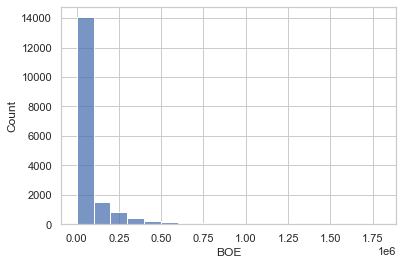

In [79]:
sns.histplot(data=well_prd_total, x="BOE", binwidth=100000)

In [72]:
well_prod_df.head()

,rpt_date,API_WELLNO,ST_FMTN_CD,Name_,Lease_Unit,OPNO,CoName,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,STATUS,dt_mod
0,12/30/1899,25035061990000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
1,12/30/1899,25035062030000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
2,12/30/1899,25035062220000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
3,12/30/1899,25035062380000,CB,Cut Bank,2593.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/13/2020
4,12/30/1899,25035062860000,CB,Cut Bank,2203.0,1770.0,Cut Bank Gas Company,0.0,0.0,0,0.0,False,NaN,04/10/2020


<AxesSubplot:xlabel='BOE', ylabel='Count'>

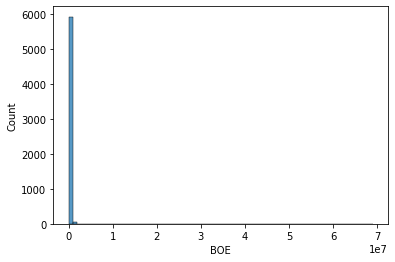

In [56]:
sns.histplot(data=lease_prd_total, x="BOE", binwidth=1000000)

# Horizontal Wells
Most activity over the past two decade in Montana has been focused on horizontal drilling on the western flank of the Williston Basin.

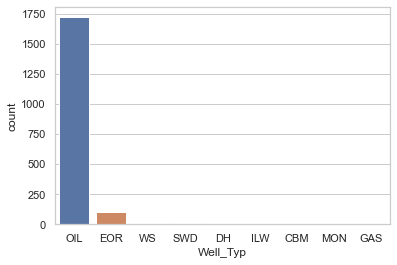

In [87]:
hz_wells = well_data_df[well_data_df['Slant'] == 'H']

sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Well_Typ", data=hz_wells)

Almost all these wells appear to be Oil wells. It's possible that wells that were initially completed as oil wells may have been converted to EOR as production fell. 

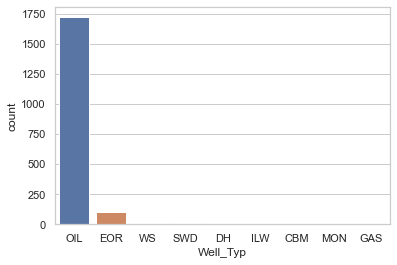

In [86]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Well_Typ", data=hz_wells)

We can subset our production data to include only horizontal wells that are in the `EOR` or `OIL` categories

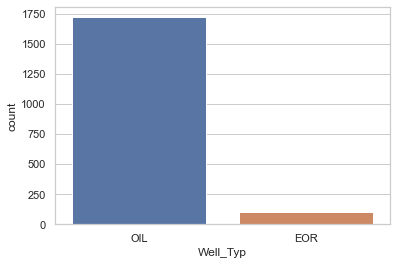

In [89]:
hz_wells = hz_wells[(hz_wells['Well_Typ'] == 'OIL') | (hz_wells['Well_Typ'] == 'EOR')] #filter well types

#plot categories after filtering
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Well_Typ", data=hz_wells)

#
hz_wells_list = list(hz_wells['API_WellNo'])

In [90]:
hz_wells_prod = well_prod_df[well_prod_df['API_WELLNO'].isin(hz_wells_list)]
hz_wells_prod.head()

,rpt_date,API_WELLNO,ST_FMTN_CD,Name_,Lease_Unit,OPNO,CoName,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,STATUS,dt_mod
545,01/31/1986,25021050590000,SO,Siluro-Ordovician,4541.0,NaN,NaN,21.0,0.0,57,5.0,False,P,NaN
4387,01/31/1986,25085214600000,RR,Red River,3257.0,NaN,NaN,610.0,660.0,83,28.0,False,P,NaN
4754,01/31/1986,25091215250000,RR,Red River,3276.0,NaN,NaN,1222.0,934.0,11023,31.0,False,P,NaN
7327,02/28/1986,25021050590000,SO,Siluro-Ordovician,4541.0,NaN,NaN,91.0,0.0,234,16.0,False,P,NaN
11122,02/28/1986,25085214600000,RR,Red River,3257.0,NaN,NaN,793.0,893.0,84,28.0,False,P,NaN


In [91]:
hz_wells_prod['Name_'].value_counts()

Bakken                    181983
Siluro-Ordovician          31160
Red River                  29115
Ratcliffe                  11530
Nisku                       4559
Sawtooth                    3801
Madison                     2496
Three Forks                 1936
Mission Canyon              1825
Cut Bank                    1404
Charles C                   1397
Heath                       1188
Amsden                       695
Greybull                     575
Gunton                       386
Winnipegosis                 340
Sunburst                     231
Charles B                    226
Lodgepole                    222
McGowan Zone                 155
Bowes Member                 109
Cone Calcareous Member        84
Mowry Shale                   47
Greenhorn                     30
Tyler                         25
Dawson Bay                    12
Unknown                       11
Sun River Dolomite            11
Jefferson Formation            3
Name: Name_, dtype: int64

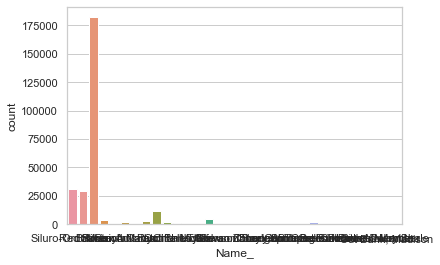

In [83]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Name_", data=hz_wells_prod)

sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Well_Typ", data=hz_wells)

# Merge 

There are two ways that we can look at our data, we can choose to look through the lenses of leases which will contain a collection of 1 or more wells. The other is to perform analysis on a per well Basis. Each well will have a unique `API_WellNo` and each lease will be associated with a unique `Lease_Unit`. Our focus here will be on wells drilled horizontally, denoted by the `Slant` field in the `well_data_df`

In [57]:
hz_wells = well_data_df[well_data_df['Slant'] == 'H']
hz_wells_list = list(hz_wells['API_WellNo'])
hz_wells_prod = well_prod_df[well_prod_df['API_WELLNO'].isin(hz_wells_list)]
hz_wells_prod

,rpt_date,API_WELLNO,ST_FMTN_CD,Name_,Lease_Unit,OPNO,CoName,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,STATUS,dt_mod
545,01/31/1986,25021050590000,SO,Siluro-Ordovician,4541.0,NaN,NaN,21.0,0.0,57,5.0,False,P,NaN
4387,01/31/1986,25085214600000,RR,Red River,3257.0,NaN,NaN,610.0,660.0,83,28.0,False,P,NaN
4754,01/31/1986,25091215250000,RR,Red River,3276.0,NaN,NaN,1222.0,934.0,11023,31.0,False,P,NaN
7327,02/28/1986,25021050590000,SO,Siluro-Ordovician,4541.0,NaN,NaN,91.0,0.0,234,16.0,False,P,NaN
11122,02/28/1986,25085214600000,RR,Red River,3257.0,NaN,NaN,793.0,893.0,84,28.0,False,P,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028196,10/31/2021,25085217940000,TF,Three Forks,8445.0,794.0,"Foundation Energy Management, LLC",270.0,437.0,765,31.0,False,NaN,11/12/2021
5028197,10/31/2021,25085218010000,TF,Three Forks,8727.0,794.0,"Foundation Energy Management, LLC",0.0,0.0,0,0.0,False,NaN,11/12/2021
5028198,10/31/2021,25085218410000,TF,Three Forks,8766.0,794.0,"Foundation Energy Management, LLC",162.0,154.0,751,31.0,False,NaN,11/12/2021
5028199,10/31/2021,25085218550000,TF,Three Forks,8765.0,794.0,"Foundation Energy Management, LLC",130.0,399.0,795,31.0,False,NaN,11/12/2021


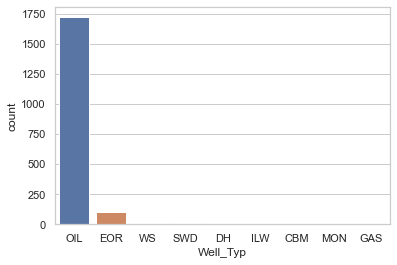

In [75]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Well_Typ", data=hz_wells)